# Modélisation risque de crédit

## 1. Introduction 
Ce projet vise à construire un modèle de prédiction du défaut de paiement des clients d’une institution financière à partir de leurs données personnelles, historiques de paiement, montants facturés et remboursés.

L'enjeu est d'identifier les clients à haut risque de défaut, afin d'optimiser la gestion du crédit et de limiter les pertes.

Les données sont issues d’un jeu réel contenant :

🎯 Variable cible :

- Y : default payment next month
→ 0 = pas de défaut, 1 = défaut de paiement.

🔹 Informations personnelles :

- LIMIT_BAL	: montant du crédit accordé (NT$)

- SEX	: sexe (1 = homme, 2 = femme)

- EDUCATION	: niveau d'éducation (1 = supérieur, 2 = université, etc.)

- MARRIAGE	: statut marital (1 = marié, 2 = célibataire, etc.)

- AGE	: âge (en années)

🔹 Historique de remboursement :

- PAY_0 à PAY_6	: Historique de paiement des 6 derniers mois.

- -1 : paiement dû mais payé dans les délais

- 0 : payé à temps

- 1~9 : retard de 1 à 9 mois

- 2 ou plus = indicateur de défaut

🔹 Montants de facturation :

- BILL_AMT1 à BILL_AMT6 : Montant de la facture mensuelle des 6 derniers mois (NT$)

🔹 Montants remboursés :

- PAY_AMT1 à PAY_AMT6 :	Montant payé chaque mois par le client

Après avoir exploré les données, nous avons dans un premier temps réalisé une régression logistique simple, puis avec la méthode de SMOTE pour corriger les déséquilibre, et enfin nous avons implémenter la méthode de Variational Autoencoder (VAE), qui est une méthode de Deep Learning plus avancée. 

Pour plus de lisibilité, nous avons créé un module data_mining_kit qui contient nos fonctions et classes auxquelles on fait appel.

### Exploration des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import data_mining_kit as dmk

# Données
data=pd.read_excel('default.xls', header=1, index_col=0)

In [2]:
data.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
print(data.shape)
print(data.columns)
print(data['default payment next month'].value_counts())

(30000, 24)
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
default payment next month
0    23364
1     6636
Name: count, dtype: int64


### Analyse des données

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

Nous ne constatons aucune valeur manquante

In [6]:
data.SEX.unique()

array([2, 1])

Nous voyons qu'il n'y a pas d'autres valeurs que 1 et 2, donc il n'y a pas d'erreur.

In [7]:
data.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0])

De même pour l'éducation, il ne semble pas y avoir d'erreurs. 

In [8]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


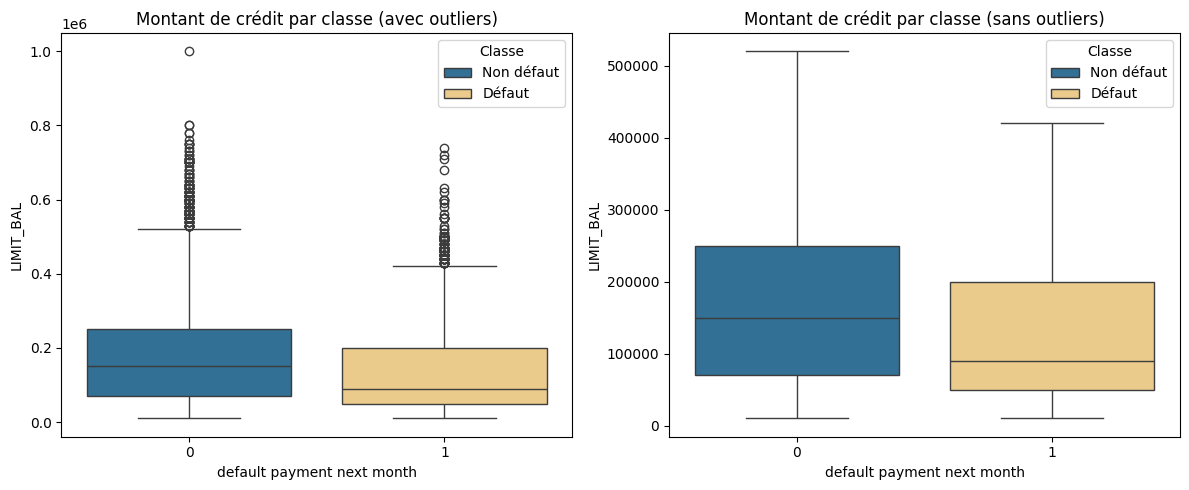

In [9]:
dmk.boxplot(data)

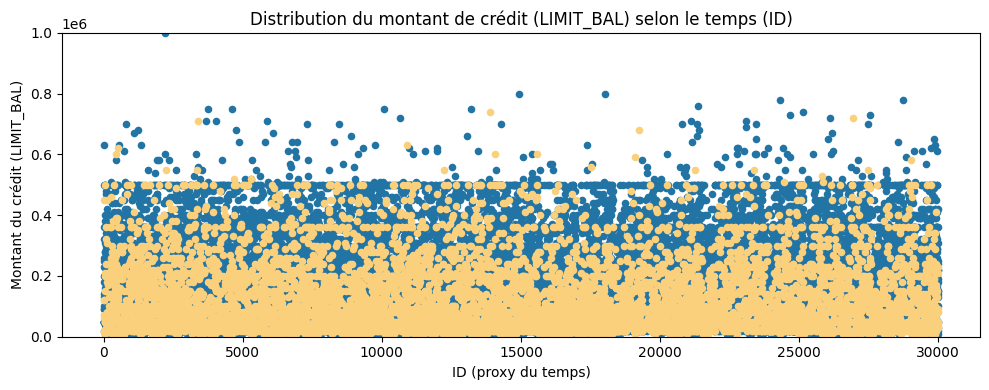

In [10]:
dmk.scatterplot(data)

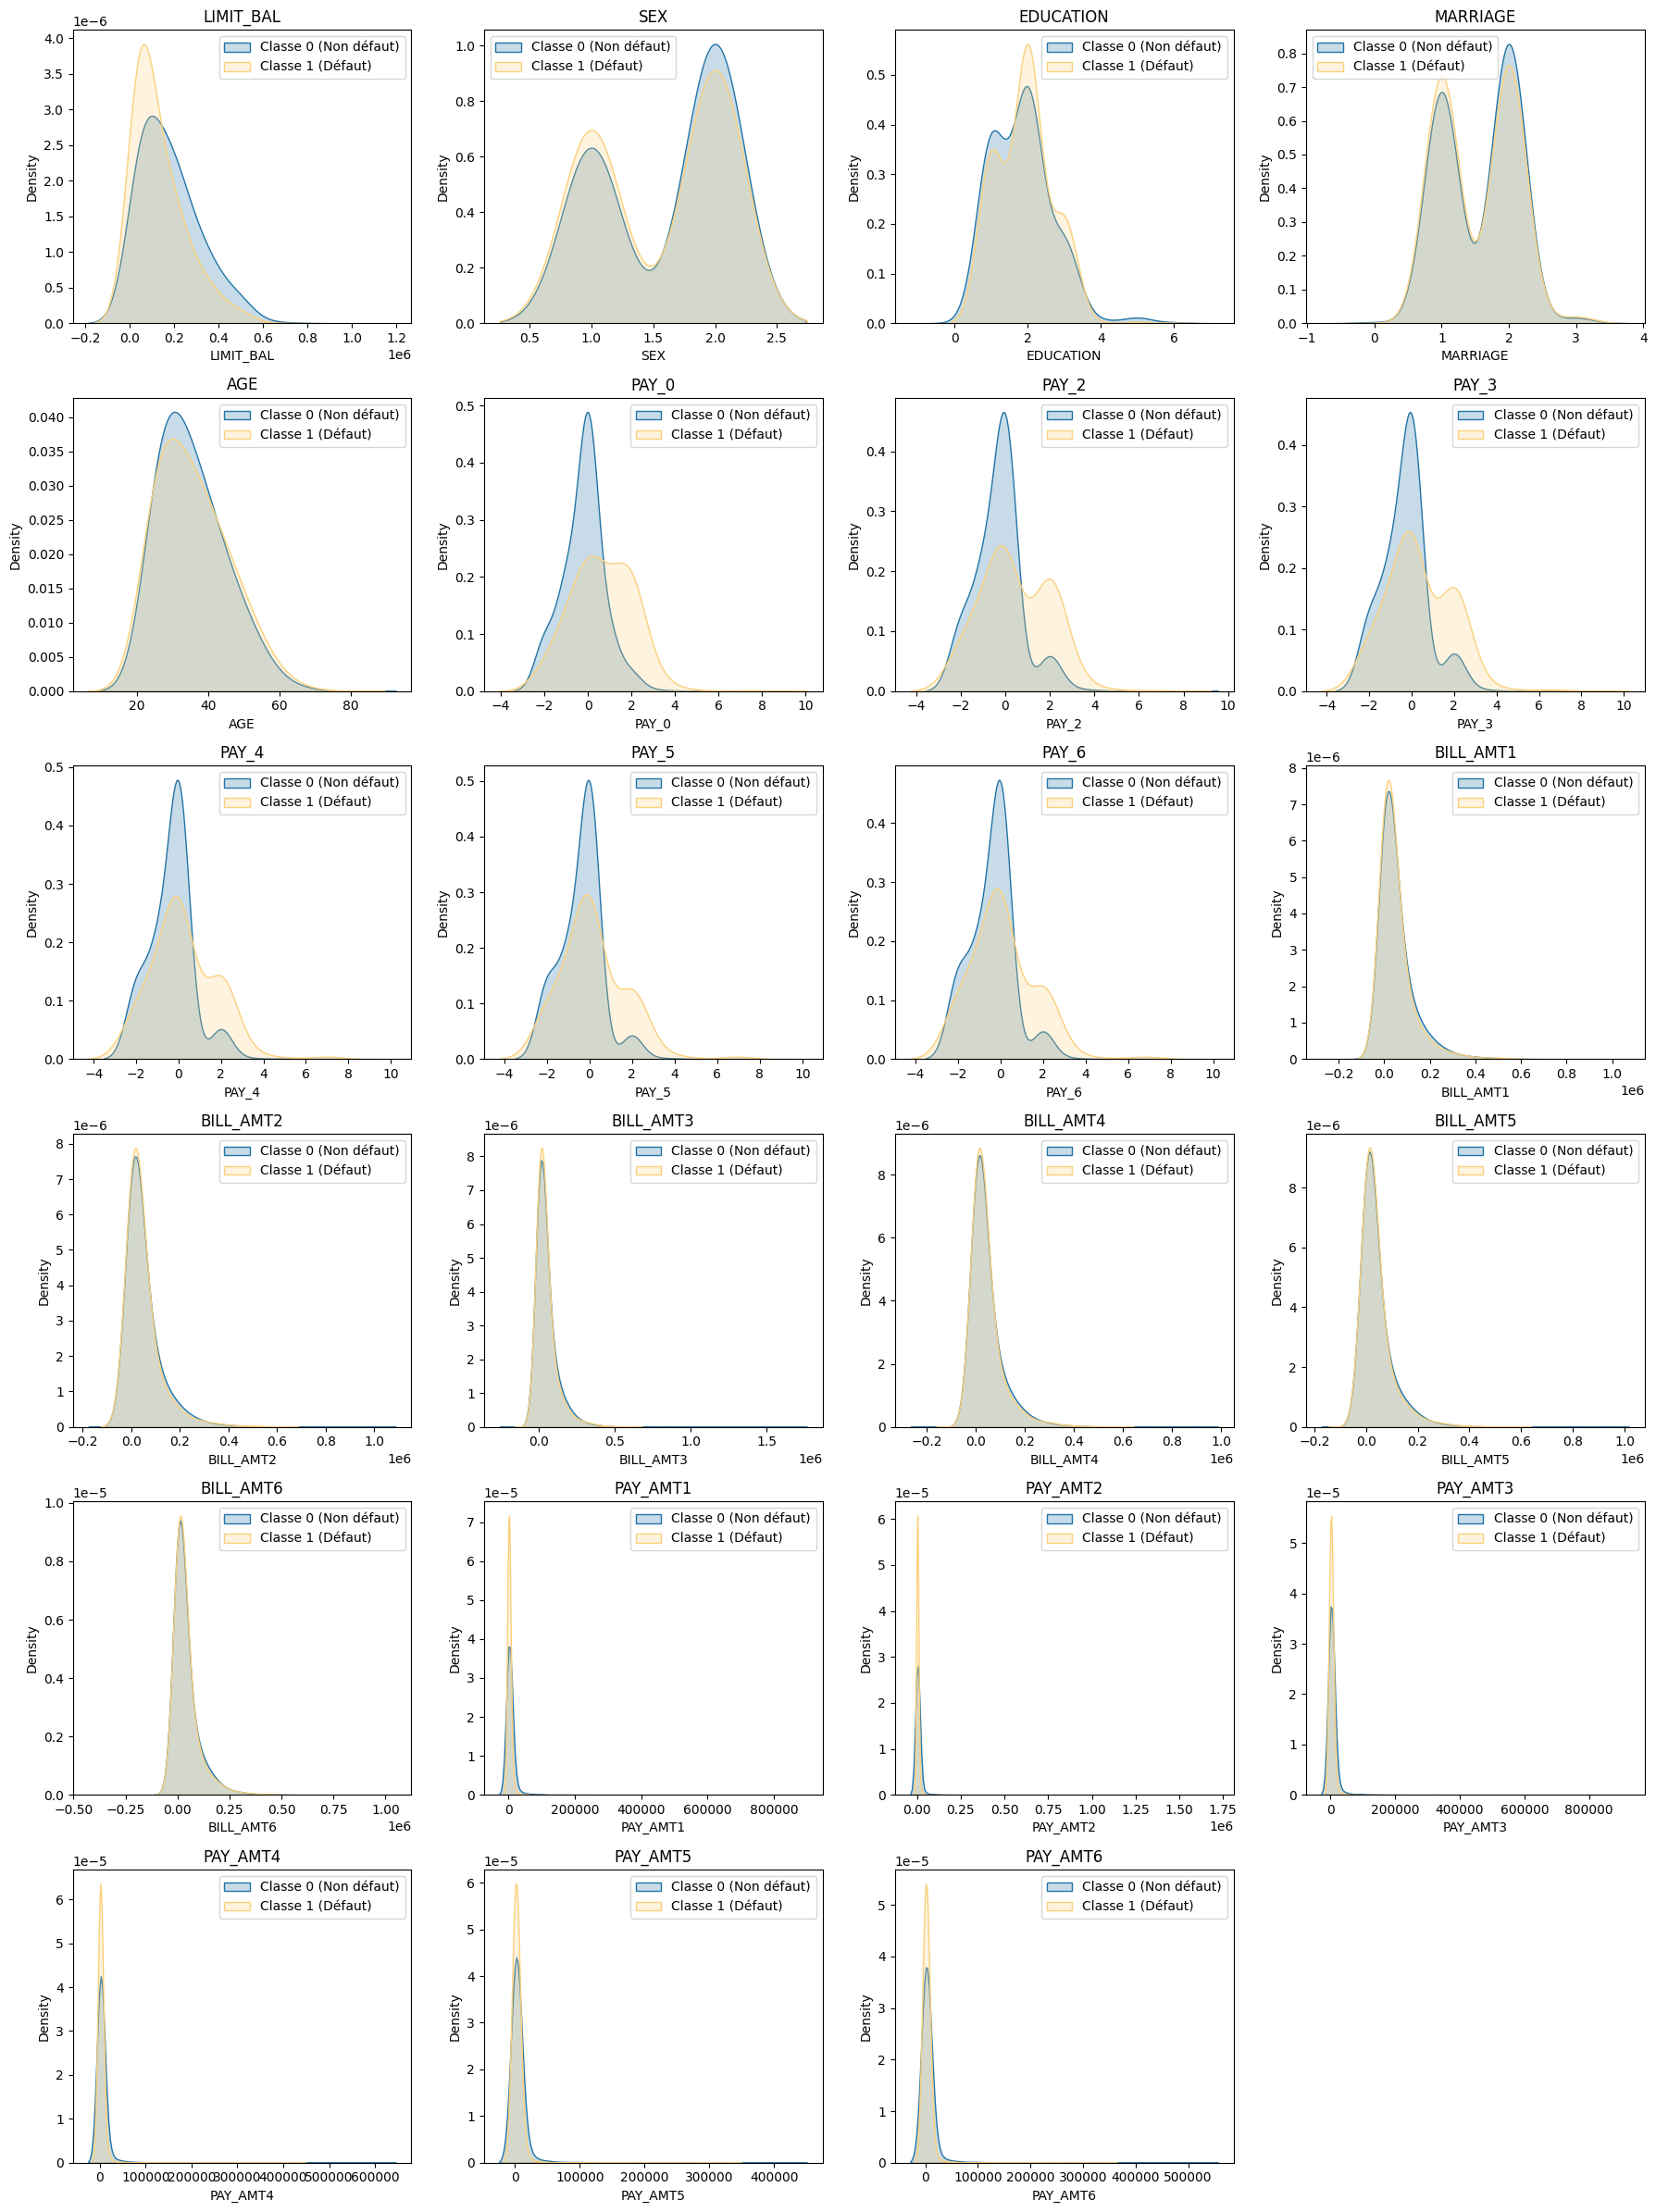

In [11]:
dmk.distribution(data)

In [12]:
dmk.pourcentage(data)

La part de classe 1 est : 22.1 %
La part de classe 0 est : 77.9 %


Nous constatons une surprésentation de la classe 0. Cela veut dire que même quand on construit un modèle très mauvais qui ne peut prédire aucune classe positive, on aura l'impréssion d'avoir un bon modèle si on se contente de voir certaines métrique telle que l'accuracy par exemple. Nous allons dans un premier temps implémenter un modèle logistique simple (1); ensuite nous allons implémenter un modèle qui tienne compte de cette différence de poids entre les deux classe, le modèle SMOTE (2); enfin nous implémenterons le modèle VAE (3). 

# 2. Modélisation

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import data_mining_kit as dmk

In [15]:
# Appel des fonctions du module
X_train, X_test, y_train, y_test = dmk.modelisation(data)

### 1. Modèle de regression logistique

In [16]:
dmk.logistique(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

ROC AUC: 0.7149950852455682


#### 1.1 Performance globale
- Accuracy : 81 %. Le modèle prédit correctement 81 % des cas. Cela semble bon, mais il y a un déséquilibre des classes. En effet il y a 77.88% de classe 0 contre 22.12% de classe 1. 

- ROC AUC : 0.71. C’est un score modéré. Cela signifie que le modèle a une capacité raisonnable à distinguer entre les classes positives et négatives, mais pas excellente.

- Recall classe 1 : 0.24. Le modèle détecte seulement 24 % des vrais positifs. C’est très bas : le modèle manque la majorité des cas de défaut de paiement (si c’est le contexte). Autrement dit : beaucoup de faux négatifs.

- F1-score classe 1 : 0.35. Faible également. Cela reflète un mauvais équilibre entre précision et rappel pour cette classe.

#### 1.2 Bonne performance sur la classe 0
- Recall classe 0 : 0.97

- Precision classe 0 : 0.82

- F1-score classe 0 : 0.89

- Le modèle est très bon pour détecter les non-défaillants. Mais c’est souvent moins critique en pratique.

### 2. Modèle Smote

In [17]:
#pip install imblearn

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
dmk.smote(data)

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      7009
           1       0.36      0.64      0.46      1991

    accuracy                           0.67      9000
   macro avg       0.62      0.66      0.61      9000
weighted avg       0.76      0.67      0.70      9000

ROC AUC: 0.7177378457015766


#### 2.1 Performance globale
- Accuracy : 67 %. Le modèle prédit correctement 67 % des cas. Cela semble bon, mais il y a un déséquilibre des classes. En effet il y a 77.88% de classe 0 contre 22.12% de classe 1. 

- ROC AUC : 72 %. C’est un score modéré. Cela signifie que le modèle a une capacité raisonnable à distinguer entre les classes positives et négatives, mais pas excellente.

- Recall classe 1 : 64 %. On a amélioré considérablement la prédiction des vrais positifs par rapport au modèle logistique. Le modèle est assez bon pour détecter les vrais positifs, mais pas très bon. 

- F1-score classe 1 : 46 %. C'est toujours mieux que le modèle logistique précédent.

#### 2.2 Bonne performance sur la classe 0
- Recall classe 0 : 0.68

- Precision classe 0 : 0.87

- F1-score classe 0 : 0.76

- Le modèle reste bon pour détecter les non-défaillants.

### 3 Variational Autoencoders (VAE) et Application au Risque de Crédit

---

Un autoencoder est un réseau de neurones entraîné pour reconstruire son entrée. Il est composé de :

- **Encodeur** : compresse les données d’entrée en un vecteur latent de dimension réduite.  
- **Décodeur** : reconstruit les données originales à partir du vecteur latent.

L’objectif est d’apprendre une représentation compacte des données, souvent pour la réduction de dimension ou la détection d’anomalies.

---

#### 3.1 Variational Autoencoders (VAE) — Concept

Les VAE sont une extension probabiliste des autoencoders classiques. Contrairement à un encodage déterministe, le VAE encode les données en une **distribution latente** (souvent gaussienne).

##### Fonctionnement clé

L’encodeur produit deux vecteurs :

- \( \mu \) (moyenne)  
- \( \sigma \) (écart-type)  

d’une distribution gaussienne multivariée.

On échantillonne un vecteur latent \( z \) depuis cette distribution :  
\[
z \sim \mathcal{N}(\mu, \sigma^2)
\]

Le décodeur reconstruit les données à partir de \( z \).

##### Pourquoi cette approche ?

- Permet de **générer de nouvelles données** en échantillonnant aléatoirement dans l’espace latent.  
- Le modèle apprend une **distribution structurée** dans l’espace latent.  
- Favorise une meilleure **régularisation** et **généralisation**.

---

#### 3.2 Fonction de perte du VAE

La fonction de perte combine :

- **Reconstruction loss** : mesure la qualité de la reconstruction (ex : erreur quadratique moyenne).  
- **KL divergence** : force la distribution latente à se rapprocher d’une distribution normale standard \( \mathcal{N}(0, I) \).

La fonction s’écrit :

\[
\mathcal{L} = \mathbb{E}_{q_\phi(z|x)} \big[ \log p_\theta(x|z) \big] - D_{KL}\big( q_\phi(z|x) \,\|\, p(z) \big)
\]

où :  
- \( q_\phi(z|x) \) est la distribution apprise par l’encodeur.  
- \( p_\theta(x|z) \) est la probabilité de reconstruction par le décodeur.  
- \( p(z) \) est la distribution prior (normale standard).

---

#### 3.3 Application au Risque de Crédit

##### Contexte

Dans la gestion du risque de crédit, on cherche souvent à :

- Détecter les clients à risque (défaillants).  
- Identifier les anomalies dans les données de remboursement.  
- Générer des scénarios synthétiques pour la simulation.

##### Pourquoi utiliser un VAE ?

- **Détection d’anomalies :**  
  Un VAE entraîné sur des clients non défaillants apprend à bien reconstruire leurs données. Les défauts (cas anormaux) sont mal reconstruits, ce qui génère une erreur élevée détectable.

- **Représentation latente :**  
  Le VAE fournit un vecteur latent compact, exploitable comme feature d’entrée dans des modèles prédictifs classiques (régression logistique, random forest…).

- **Génération de données synthétiques :**  
  Pour augmenter les données de défauts rares, le VAE peut générer des exemples réalistes.

##### Exemple d’usage concret

1. Entraîner un VAE sur les clients sans défaut.  
2. Calculer l’erreur de reconstruction sur de nouveaux clients.  
3. Si l’erreur est élevée → suspicion de comportement atypique → risque de défaut plus élevé.  
4. Utiliser la représentation latente dans un modèle prédictif combiné.

---

#### 3.4 Limites et précautions

- Les VAE nécessitent un volume important de données pour bien apprendre la distribution.  
- Le choix des dimensions latentes et des hyperparamètres impacte fortement la qualité.  
- Les VAE peuvent générer des données réalistes mais pas toujours fidèles aux cas extrêmes.  
- L’interprétabilité des vecteurs latents peut être faible.

---

#### 3.5 Exemple simple de code en Python avec Keras

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Supposons que X_train est ton jeu de données d'entrée en numpy array
X_train = X_train.astype(np.float32)  # conversion en float32 (important)

# Créer le modèle VAE (input_dim = nombre de features)
input_dim = X_train.shape[1]
latent_dim = 10  # par exemple

vae = dmk.VAE(input_dim=input_dim, latent_dim=latent_dim)

# Choisir un batch ou tout le dataset (petit dataset possible)
batch = tf.convert_to_tensor(X_train[:64], dtype=tf.float32)

# Calculer la loss sur ce batch
loss = dmk.compute_loss(vae, batch)
print("Loss sur le batch :", loss.numpy())

Loss sur le batch : 1.2845982


In [22]:
input_dim = X_train.shape[1]
latent_dim = 10  # tu peux ajuster cette dimension

vae = dmk.VAE(input_dim=input_dim, latent_dim=latent_dim)

# Entraînement
dmk.train_vae(vae, X_train.astype(np.float32), epochs=30, batch_size=64)

Epoch 1, Loss: 0.9879
Epoch 2, Loss: 0.9443
Epoch 3, Loss: 0.9404
Epoch 4, Loss: 0.9356
Epoch 5, Loss: 0.9308
Epoch 6, Loss: 0.9265
Epoch 7, Loss: 0.9227
Epoch 8, Loss: 0.9165
Epoch 9, Loss: 0.9098
Epoch 10, Loss: 0.9096
Epoch 11, Loss: 0.9073
Epoch 12, Loss: 0.9058
Epoch 13, Loss: 0.9044
Epoch 14, Loss: 0.9028
Epoch 15, Loss: 0.9026
Epoch 16, Loss: 0.8993
Epoch 17, Loss: 0.9009
Epoch 18, Loss: 0.8991
Epoch 19, Loss: 0.8981
Epoch 20, Loss: 0.8971
Epoch 21, Loss: 0.8974
Epoch 22, Loss: 0.8966
Epoch 23, Loss: 0.8972
Epoch 24, Loss: 0.8967
Epoch 25, Loss: 0.8960
Epoch 26, Loss: 0.8944
Epoch 27, Loss: 0.8952
Epoch 28, Loss: 0.8953
Epoch 29, Loss: 0.8947
Epoch 30, Loss: 0.8959


**Reconstruction et évaluation**

- On passe les données d’entrée dans le VAE pour voir à quel point il les reconstruit bien.

- On prend un batch, encoder, décoder, puis comparer les données originales et reconstruites.

- Ça nous donne une idée de la qualité de la compression et reconstruction.

In [23]:
# Reconstruction sur des données de test
x_test = X_test.astype(np.float32)
mean, logvar = vae.encode(x_test)
z = vae.reparameterize(mean, logvar)
x_recon = vae.decode(z).numpy()
# Comparaison visuelle ou statistique entre x_test et x_recon

**Visualiser l’espace latent**

- Extraire z pour les données via encode + reparameterize.

- Réduire la dimension (si latent_dim > 2) avec t-SNE ou PCA.

- Visualiser les clusters ou classes dans cet espace latent.

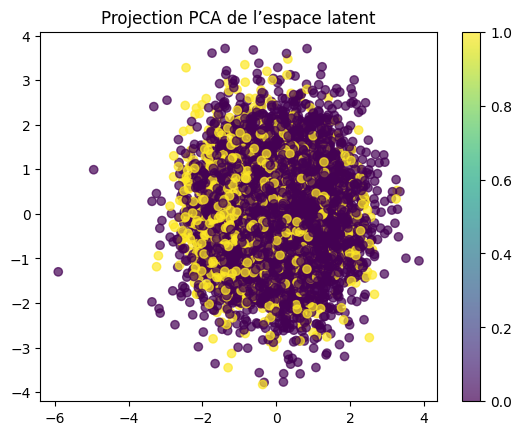

In [24]:
dmk.visualisation_espace_latent(data, vae, X_test, y_test)

**Utiliser les représentations latentes pour la classification**

- Entraîner un classifieur (ex : LogisticRegression, RandomForest, XGBoost...) sur les vecteurs latents z pour prédire la cible.

- Ça permet d’évaluer la pertinence des features extraites par le VAE.

#### Avec la régression logistique

In [25]:
dmk.resultat_avec_reg_logistique(z, y_test)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.20      0.00      0.00      1991

    accuracy                           0.78      9000
   macro avg       0.49      0.50      0.44      9000
weighted avg       0.65      0.78      0.68      9000



Le modèle est très mauvais pour prédire la classe cible (1). 

#### Avec XGBoost

In [32]:
grid_search = dmk.xgboost(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [33]:
dmk.resultat_avec_xgboost(X_test, y_test, grid_search)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      7009
           1       0.47      0.62      0.54      1991

    accuracy                           0.76      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.76      0.77      9000

ROC AUC: 0.7783839519240492


On voit une amélioration avec XGBoost. Le modèle arrive à prédire la classe positive, même si la précision n'est bonne (47%). 

In [34]:
dmk.logistique(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

ROC AUC: 0.7149950852455682


Une comparaison visuelle des deux modèle (le modèle logistique avec les données d'entrées et le modèle XGBoost avec les représentations latentes) montre qu'il y a une nette amélioration au niveau du recall, du f1-score de la classe 1 et du ROC. 
Cependant la précision a diminué. 